In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv


In [2]:
import pandas as pd

# On utilise le chemin exact que l'on voit sur ton image
path = "/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz"

print("Chargement en cours... (patience !)")
df = pd.read_csv(path, compression='gzip', low_memory=False)

print("Chargement terminé !")
print(f"Lignes : {df.shape[0]}")
print(f"Colonnes : {df.shape[1]}")

# On compte les colonnes trop vides
missing = df.isnull().mean() * 100
cols_vides = missing[missing > 50].count()
print(f"Il y a {cols_vides} colonnes vides à plus de 50%.")

Chargement en cours... (patience !)
Chargement terminé !
Lignes : 2260701
Colonnes : 151
Il y a 44 colonnes vides à plus de 50%.


In [3]:
# 1. On supprime les colonnes qui ont plus de 50% de vide
df = df.dropna(thresh=df.shape[0]*0.5, axis=1)

print(f"Colonnes restantes après nettoyage : {df.shape[1]}")

# 2. On regarde la colonne "loan_status" (notre cible à prédire)
print("\n--- États des prêts (loan_status) ---")
print(df['loan_status'].value_counts())

Colonnes restantes après nettoyage : 107

--- États des prêts (loan_status) ---
loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64


In [4]:
# 1. On ne garde que les prêts terminés (Soit payés, soit en défaut)
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

# 2. On transforme le texte en chiffres (Binaire)
# Fully Paid -> 0 (Pas de risque)
# Charged Off -> 1 (Risque / Défaut)
mapping = {'Fully Paid': 0, 'Charged Off': 1}
df['loan_status'] = df['loan_status'].map(mapping)

print(f"Nombre de lignes restantes : {df.shape[0]}")

# 3. Vérification de la proportion (Déséquilibre des classes)
distribution = df['loan_status'].value_counts(normalize=True) * 100
print("\n--- Distribution finale ---")
print(f"Bons payeurs (0) : {distribution[0]:.2f}%")
print(f"Mauvais payeurs (1) : {distribution[1]:.2f}%")

Nombre de lignes restantes : 1345310

--- Distribution finale ---
Bons payeurs (0) : 80.04%
Mauvais payeurs (1) : 19.96%


In [5]:
import pandas as pd

# --- ÉTAPE 1 : CHARGEMENT ---
path = "/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz"
print("1. Chargement des données en cours...")
df = pd.read_csv(path, compression='gzip', low_memory=False)

# --- ÉTAPE 2 : NETTOYAGE GROSSIER ---
# On supprime les colonnes trop vides
df = df.dropna(thresh=df.shape[0]*0.5, axis=1)

# --- ÉTAPE 3 : FILTRAGE DE LA CIBLE ---
# On ne garde que 'Fully Paid' et 'Charged Off'
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

# --- ÉTAPE 4 : ENCODAGE (0 et 1) ---
mapping = {'Fully Paid': 0, 'Charged Off': 1}
df['loan_status'] = df['loan_status'].map(mapping)

# --- RÉSULTAT ---
print("\n--- TERMINE ! ---")
print(f"Nombre de lignes restantes : {df.shape[0]}")
distribution = df['loan_status'].value_counts(normalize=True) * 100
print(f"Bons payeurs (0)    : {distribution[0]:.2f}%")
print(f"Mauvais payeurs (1) : {distribution[1]:.2f}%")

1. Chargement des données en cours...

--- TERMINE ! ---
Nombre de lignes restantes : 1345310
Bons payeurs (0)    : 80.04%
Mauvais payeurs (1) : 19.96%


In [6]:
# --- SÉLECTION DES VARIABLES PERTINENTES ---
# On ne garde que ce que la banque connait AU DEBUT du prêt
features_a_garder = [
    'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
    'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
    'purpose', 'dti', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
    'initial_list_status', 'application_type', 'mort_acc',
    'pub_rec_bankruptcies', 'loan_status' 
]

df_clean = df[features_a_garder].copy()

# --- TRAITEMENT DES VALEURS MANQUANTES ---
print("--- Valeurs manquantes avant remplissage ---")
print(df_clean.isnull().sum()[df_clean.isnull().sum() > 0])

# Pour simplifier, on remplit les vides intelligemment :
# - 'mort_acc' (comptes hypothécaires) -> on remplace vide par 0
df_clean['mort_acc'] = df_clean['mort_acc'].fillna(0)
# - 'pub_rec_bankruptcies' (faillites) -> on remplace vide par 0
df_clean['pub_rec_bankruptcies'] = df_clean['pub_rec_bankruptcies'].fillna(0)
# - 'revol_util' et 'dti' -> on remplace par la moyenne
df_clean['revol_util'] = df_clean['revol_util'].fillna(df_clean['revol_util'].mean())
df_clean['dti'] = df_clean['dti'].fillna(df_clean['dti'].mean())
# - On supprime les rares lignes restantes avec des vides (emp_length par ex)
df_clean = df_clean.dropna()

print("\n--- Dimensions finales ---")
print(f"Lignes : {df_clean.shape[0]}")
print(f"Colonnes : {df_clean.shape[1]}")

--- Valeurs manquantes avant remplissage ---
emp_length              78511
dti                       374
revol_util                857
mort_acc                47281
pub_rec_bankruptcies      697
dtype: int64

--- Dimensions finales ---
Lignes : 1266799
Colonnes : 21


In [7]:
# 1. On convertit la durée (term) en chiffre (36 ou 60)
# On prend le premier mot de la chaîne (ex: "36" de " 36 months")
df_clean['term'] = df_clean['term'].apply(lambda x: int(x.split()[0]))

# 2. On convertit l'ancienneté (emp_length) en chiffre
mapping_emp = {
    '< 1 year': 0,
    '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
    '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8,
    '9 years': 9, '10+ years': 10
}
df_clean['emp_length'] = df_clean['emp_length'].map(mapping_emp)

# 3. On supprime 'grade' car 'sub_grade' contient déjà l'info
df_clean = df_clean.drop('grade', axis=1)

# 4. On transforme toutes les autres colonnes texte en colonnes numériques (0/1)
dummies = ['sub_grade', 'verification_status', 'purpose', 'initial_list_status', 
           'application_type', 'home_ownership']
df_clean = pd.get_dummies(df_clean, columns=dummies, drop_first=True)

print("--- TRANSFORMATION TERMINÉE ---")
print(f"Nouvelles dimensions : {df_clean.shape}")

--- TRANSFORMATION TERMINÉE ---
Nouvelles dimensions : (1266799, 70)


In [8]:
# 1. On sépare les classes
df_bad = df_clean[df_clean['loan_status'] == 1]
df_good = df_clean[df_clean['loan_status'] == 0]

print(f"Mauvais payeurs (originaux) : {len(df_bad)}")
print(f"Bons payeurs (originaux)    : {len(df_good)}")

# 2. On prend un échantillon de "Bons" égal au nombre de "Mauvais"
df_good_sample = df_good.sample(n=len(df_bad), random_state=42)

# 3. On recolle tout ensemble
df_balanced = pd.concat([df_bad, df_good_sample])

# 4. On mélange les lignes pour ne pas avoir les bons d'un côté et les mauvais de l'autre
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("\n--- APRÈS RÉÉQUILIBRAGE ---")
print(f"Nouvelle taille du dataset : {df_balanced.shape}")
print(df_balanced['loan_status'].value_counts(normalize=True))

Mauvais payeurs (originaux) : 247429
Bons payeurs (originaux)    : 1019370

--- APRÈS RÉÉQUILIBRAGE ---
Nouvelle taille du dataset : (494858, 70)
loan_status
0    0.5
1    0.5
Name: proportion, dtype: float64


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# 1. Séparation X (Variables) et y (Cible)
X = df_balanced.drop('loan_status', axis=1)
y = df_balanced['loan_status']

# 2. Découpage (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Normalisation (Mise à l'échelle)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Données prêtes !")
print(f"Entraînement sur : {X_train.shape[0]} cas")
print(f"Test sur : {X_test.shape[0]} cas")

# --- MODÈLE 1 : LOGISTIC REGRESSION (La référence) ---
print("\n1. Entraînement de la Régression Logistique en cours...")
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train_scaled, y_train)

# Prédiction
y_pred = model_lr.predict(X_test_scaled)

# Résultat
print("--- RÉSULTATS (Logistic Regression) ---")
print(f"Précision globale (Accuracy) : {accuracy_score(y_test, y_pred):.4f}")
print("\nDétails :")
print(classification_report(y_test, y_pred))

Données prêtes !
Entraînement sur : 395886 cas
Test sur : 98972 cas

1. Entraînement de la Régression Logistique en cours...
--- RÉSULTATS (Logistic Regression) ---
Précision globale (Accuracy) : 0.6530

Détails :
              precision    recall  f1-score   support

           0       0.66      0.63      0.65     49660
           1       0.64      0.68      0.66     49312

    accuracy                           0.65     98972
   macro avg       0.65      0.65      0.65     98972
weighted avg       0.65      0.65      0.65     98972



In [10]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
import time

# On prépare la liste des combattants
models = {
    "2. Arbre de Décision" : DecisionTreeClassifier(max_depth=10),
    "3. Naive Bayes"       : BernoulliNB(),
    "4. Random Forest"     : RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42),
    "5. Gradient Boosting" : GradientBoostingClassifier(n_estimators=50, random_state=42)
}

print("--- DÉBUT DU TOURNOI ---")

results = {}

for name, model in models.items():
    print(f"\nEntraînement de : {name}...")
    start_time = time.time()
    
    # Entraînement
    model.fit(X_train_scaled, y_train)
    
    # Prédiction
    acc = model.score(X_test_scaled, y_test)
    results[name] = acc
    
    end_time = time.time()
    print(f"--> Terminé en {end_time - start_time:.1f} secondes.")
    print(f"--> Précision (Accuracy) : {acc:.4f}")

print("\n--- CLASSEMENT FINAL ---")
# On ajoute ton premier score pour comparer
results["1. Logistic Regression"] = 0.6530 

# On affiche le classement
for name, score in sorted(results.items(), key=lambda item: item[1], reverse=True):
    print(f"{name} : {score:.4f}")

--- DÉBUT DU TOURNOI ---

Entraînement de : 2. Arbre de Décision...
--> Terminé en 5.6 secondes.
--> Précision (Accuracy) : 0.6451

Entraînement de : 3. Naive Bayes...
--> Terminé en 0.6 secondes.
--> Précision (Accuracy) : 0.6440

Entraînement de : 4. Random Forest...
--> Terminé en 33.0 secondes.
--> Précision (Accuracy) : 0.6449

Entraînement de : 5. Gradient Boosting...
--> Terminé en 86.6 secondes.
--> Précision (Accuracy) : 0.6521

--- CLASSEMENT FINAL ---
1. Logistic Regression : 0.6530
5. Gradient Boosting : 0.6521
2. Arbre de Décision : 0.6451
4. Random Forest : 0.6449
3. Naive Bayes : 0.6440


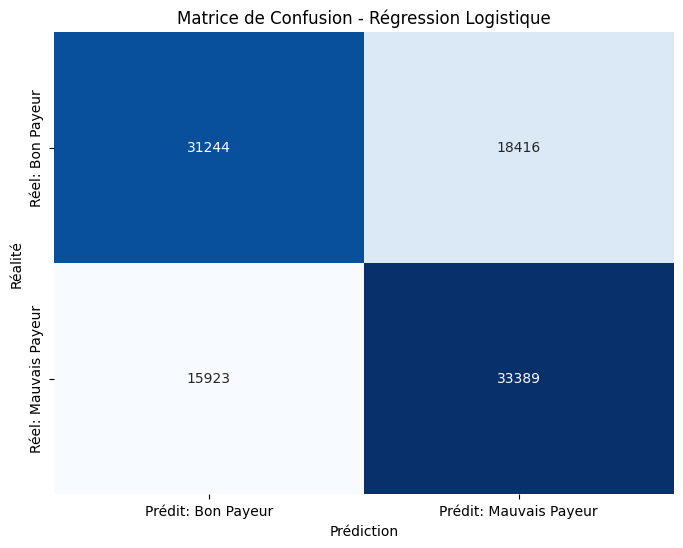

Bons clients bien détectés : 31244
Mauvais clients bien détectés : 33389
DANGER (Faux Négatifs) : 15923 mauvais payeurs classés comme 'bons'
Manque à gagner (Faux Positifs) : 18416 bons payeurs refusés à tort


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# On reprend le vainqueur : Logistic Regression
y_pred_final = model_lr.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_final)

# 1. Affichage de la Matrice de Confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Prédit: Bon Payeur', 'Prédit: Mauvais Payeur'],
            yticklabels=['Réel: Bon Payeur', 'Réel: Mauvais Payeur'])
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.title('Matrice de Confusion - Régression Logistique')
plt.show()

# 2. Calcul des pourcentages d'erreurs
tn, fp, fn, tp = cm.ravel()
print(f"Bons clients bien détectés : {tn}")
print(f"Mauvais clients bien détectés : {tp}")
print(f"DANGER (Faux Négatifs) : {fn} mauvais payeurs classés comme 'bons'")
print(f"Manque à gagner (Faux Positifs) : {fp} bons payeurs refusés à tort")

/tmp/ipykernel_17/348672221.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Impact', y='Variable', data=feature_importance, palette=colors)


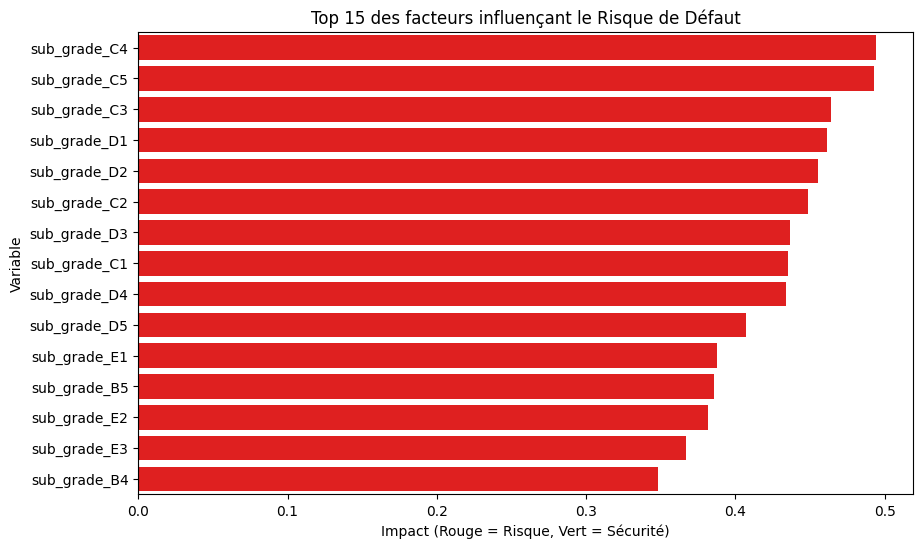

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. On récupère les noms des colonnes et les coefficients du modèle
feature_names = X.columns
coefficients = model_lr.coef_[0]

# 2. On crée un tableau propre
feature_importance = pd.DataFrame({
    'Variable': feature_names,
    'Impact': coefficients
})

# 3. On trie pour voir les plus importants (en valeur absolue)
feature_importance['Abs_Impact'] = feature_importance['Impact'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Impact', ascending=False).head(15)

# 4. Visualisation
plt.figure(figsize=(10, 6))
# On colore en Rouge si ça augmente le risque (Impact > 0), Vert si ça le diminue (Impact < 0)
colors = ['red' if x > 0 else 'green' for x in feature_importance['Impact']]
sns.barplot(x='Impact', y='Variable', data=feature_importance, palette=colors)
plt.title('Top 15 des facteurs influençant le Risque de Défaut')
plt.xlabel('Impact (Rouge = Risque, Vert = Sécurité)')
plt.axvline(x=0, color='black', linestyle='--')
plt.show()